<a href="https://colab.research.google.com/github/aakar-mutha/ITC-PROJECT/blob/main/ITC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

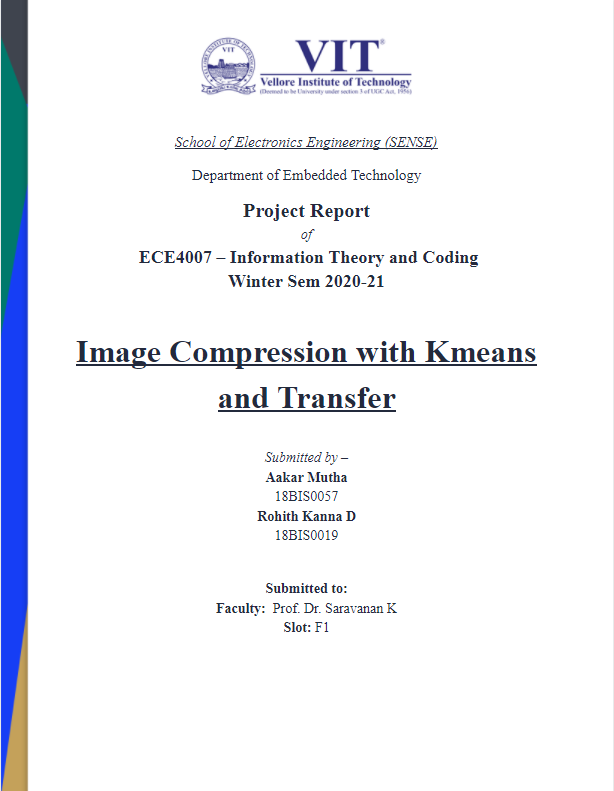

## Importing the libraries and installing the required librries.

In [ ]:
!pip3 install python_jwt

     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 3.2MB 27.5MB/s 


In [ ]:
import os
import sys

from PIL import Image
import numpy as np
from firebase_admin import credentials, initialize_app, storage,db

## Initializing the firebase application

In [ ]:
cred = credentials.Certificate("/content/key.json")
initialize_app(cred, {'storageBucket': 'image-comp-d989e.appspot.com'})
ref = db.reference("/",url = 'https://image-comp-d989e-default-rtdb.firebaseio.com/')

## Defining the Kmeans model functions

In [ ]:
def initialize_K_cent(X, K):
    m = len(X)
    return X[np.random.choice(m, K, replace=False), :]

def finding_closest_cent(X, cent):
    m = len(X)
    c = np.zeros(m)
    for i in range(m):
        distances = np.linalg.norm(X[i] - cent, axis=1)
        c[i] = np.argmin(distances)
    return c

def compute_means(X, idx, K):
    _, n = X.shape
    cent = np.zeros((K, n))
    for k in range(K):
        examples = X[np.where(idx == k)]
        mean = [np.mean(column) for column in examples.T]
        cent[k] = mean
    return cent

def finding_k_means(X, K, max_iters=10):
    cent = initialize_K_cent(X, K)
    prev_cent = cent
    for _ in range(max_iters):
        idx = finding_closest_cent(X, cent)
        cent = compute_means(X, idx, K)
        if (cent == prev_cent).all():
            return cent
        else:
            prev_cent = cent
    return cent, idx

In [ ]:
runs = 1

## Loading the image with a try except block

In [ ]:
try:
    image_path = "/content/in1.png"
    assert os.path.isfile(image_path)
except (IndexError, AssertionError):
    print('Please specify an image')

In [ ]:
def load_image(path):
    image = Image.open(path)
    image.save('in{}.png'.format(runs))
    return np.asarray(image) / 255

## Printing the Dimentions of the image

In [ ]:
image = load_image(image_path)
w, h, d = image.shape
print('Image found with width: {}, height: {}, depth: {}'.format(w, h, d))
X = image.reshape((w * h, d))

Image found with width: 960, height: 1920, depth: 3


##  Declaring the K and running the above defines functions

In [ ]:
K = 45 

In [ ]:
colors, _ = finding_k_means(X, K, max_iters=1)
idx = findingg_closest_cent(X, colors)
idx = np.array(idx, dtype=np.uint8)
X_reconstructed = np.array(colors[idx, :] * 255, dtype=np.uint8).reshape((w, h, d))
compressed_image = Image.fromarray(X_reconstructed)
compressed_image.save('out{}.jpg'.format(runs))
runs+=1

## Uploading the input image to firebase storage

In [ ]:
fileName = "in{}.png".format(runs-1)
bucket = storage.bucket()
blob = bucket.blob(fileName)
blob.upload_from_filename(fileName)

blob.make_public()

print("your file url", blob.public_url)
l1 = blob.public_url

your file url https://storage.googleapis.com/image-comp-d989e.appspot.com/in1.png


## Uploading the output image to firebase storage

In [ ]:
fileName = "out{}.jpg".format(runs-1)
bucket = storage.bucket()
blob = bucket.blob(fileName)
blob.upload_from_filename(fileName)

blob.make_public()
print("your file url", blob.public_url)

your file url https://storage.googleapis.com/image-comp-d989e.appspot.com/out1.jpg


## Placing the link to both of those images and the file size in the firebase realtime databs.

In [ ]:
ref.set({"out_link":blob.public_url,
         "out_file_size":os.path.getsize("./out{}.jpg".format(runs-1)),
         "original_link":l1,
         "original_file_size":os.path.getsize("./in{}.png".format(runs-1))})